# Customer Segmentation using RFM Analysis and K-Means Clustering

**Goal:** To segment customers from a sample sales dataset based on their purchasing behavior using Recency, Frequency, and Monetary (RFM) metrics. K-Means clustering is applied to identify distinct customer groups for potentially targeted strategies.

**Dataset:** `sales_data_sample.csv` - sample sales transactional data.

**Methodology:**
1. Load and clean the sales data.
2. Calculate Recency, Frequency, and Monetary (RFM) values for each customer.
3. Explore RFM value distributions.
4. Preprocess RFM data (Log Transform, Standard Scaling) for K-Means compatibility.
5. Use the Elbow Method to find a suitable number of clusters (k).
6. Apply K-Means clustering with the chosen k.
7. Analyze and visualize the resulting customer segments.

First, let's import all the libraries we need. I'm using pandas for data handling, numpy for numerical operations, matplotlib and seaborn for visualization, and scikit-learn for the clustering algorithm.

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

# Create a directory for saving plots if it doesn't exist
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    print(f"Created directory '{plots_dir}' for saving plots")
else:
    print(f"Directory '{plots_dir}' already exists")

print("Libraries imported successfully.")

Created directory 'plots' for saving plots
Libraries imported successfully.


Now I'll load the sample sales data. I'm using try/except to handle potential errors like missing files.

In [11]:
# Load the sales data
try:
    file_path = 'sales_data_sample.csv'  # Adjust path if needed
    df = pd.read_csv(file_path, encoding='latin1')
    print(f"Successfully loaded data. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found.")
    df = pd.DataFrame()
except Exception as e:
    print(f"Error loading the CSV: {e}")
    df = pd.DataFrame()

Successfully loaded data. Shape: (2823, 25)


Let's look at what data we have and clean it up. This is always the messiest part - gotta make sure dates are in the right format and customer names aren't missing!

In [12]:
# Data cleaning and preparation
if not df.empty:
    # Check basic info and nulls
    print("Data Info:")
    df.info()
    print("\nNull Values:")
    print(df.isnull().sum())
    
    # Remove rows without customer names
    df.dropna(subset=['CUSTOMERNAME'], inplace=True)
    print(f"Shape after cleaning: {df.shape}")
    
    # Convert order dates to datetime
    try:
        df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
    except Exception:
        # Try different date formats if default conversion fails
        try:
            df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], format='%m/%d/%Y %H:%M')
        except Exception:
            try:
                df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], format='%Y-%m-%d %H:%M:%S')
            except Exception as e3:
                print(f"Could not parse dates: {e3}")
                df = pd.DataFrame()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null 

Time for RFM calculation! This is the core of our analysis:
- Recency: how recently did the customer purchase? (fewer days = better)
- Frequency: how often do they purchase? (more = better)
- Monetary: how much do they spend? (more = better)

In [13]:
# Calculate RFM metrics
if not df.empty and 'ORDERDATE' in df.columns and pd.api.types.is_datetime64_any_dtype(df['ORDERDATE']):
    # Define snapshot date (day after latest order)
    snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days=1)
    print(f"Snapshot date: {snapshot_date.date()}")
    
    # Calculate Recency, Frequency, and Monetary Value
    df_rfm = df.groupby('CUSTOMERNAME').agg({
        'ORDERDATE': lambda x: (snapshot_date - x.max()).days,  # Recency: days since last order
        'ORDERNUMBER': 'nunique',                              # Frequency: number of orders
        'SALES': 'sum'                                         # Monetary: total spend
    })
    
    # Rename columns
    df_rfm.rename(columns={'ORDERDATE': 'Recency', 
                          'ORDERNUMBER': 'Frequency', 
                          'SALES': 'MonetaryValue'}, inplace=True)
    
    # Handle zero/negative values
    for col in ['MonetaryValue', 'Frequency']:
        if (df_rfm[col] <= 0).any():
            df_rfm[col] = df_rfm[col].apply(lambda x: 0.01 if x <= 0 else x)
            
    print("RFM metrics calculated. Sample:")
    display(df_rfm.head())
else:
    print("Could not calculate RFM values.")
    df_rfm = pd.DataFrame()

Snapshot date: 2005-06-01
RFM metrics calculated. Sample:


,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,3,157807.81
Alpha Cognac,65,3,70488.44
Amica Models & Co.,265,2,94117.26
"Anna's Decorations, Ltd",84,4,153996.13
Atelier graphique,188,3,24179.96


Let's see what our RFM distributions look like. This helps spot any weird patterns or outliers before we jump into clustering. I'm betting the monetary values will be pretty skewed (they usually are).

Saved RFM distributions plot to plots/rfm_distributions.jpg


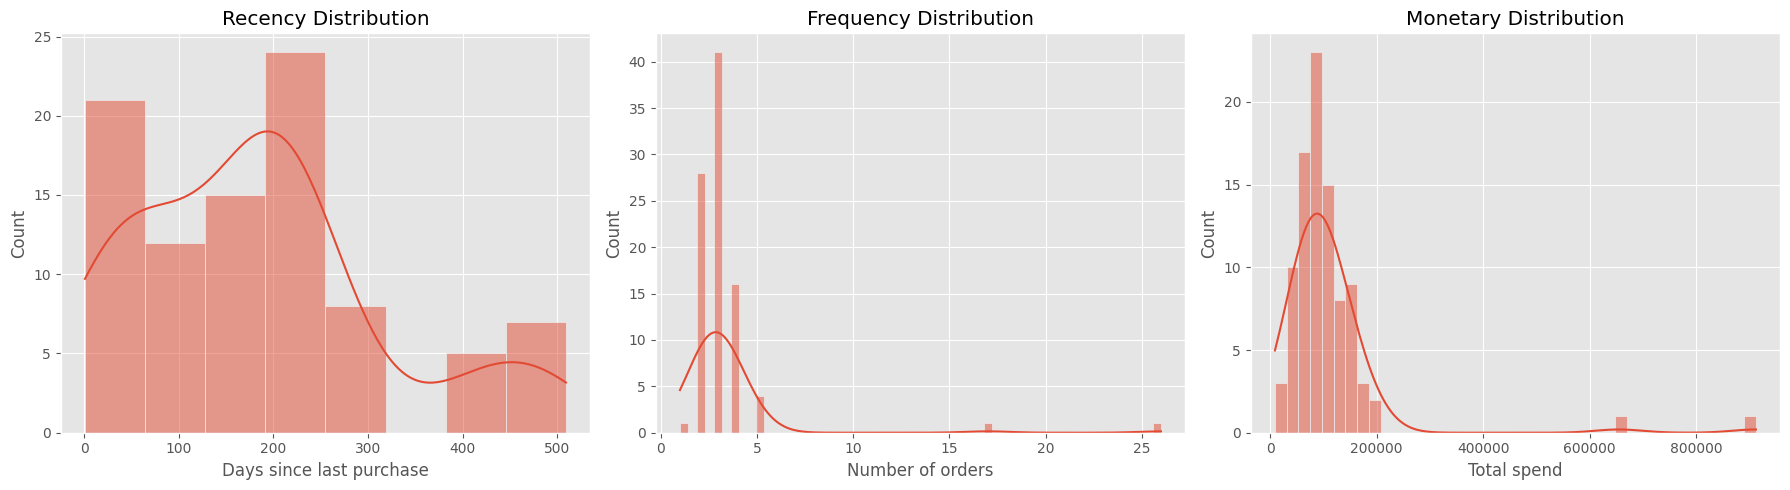

In [14]:
# Visualize RFM distributions
if not df_rfm.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.histplot(df_rfm['Recency'], kde=True, ax=axes[0])
    axes[0].set_title('Recency Distribution')
    axes[0].set_xlabel('Days since last purchase')
    
    sns.histplot(df_rfm['Frequency'], kde=True, ax=axes[1])
    axes[1].set_title('Frequency Distribution')
    axes[1].set_xlabel('Number of orders')
    
    sns.histplot(df_rfm['MonetaryValue'], kde=True, ax=axes[2])
    axes[2].set_title('Monetary Distribution')
    axes[2].set_xlabel('Total spend')
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f"{plots_dir}/rfm_distributions.jpg", dpi=300, bbox_inches='tight')
    print(f"Saved RFM distributions plot to {plots_dir}/rfm_distributions.jpg")
    
    plt.show()

## Data Preprocessing for Clustering

Before applying K-means clustering, we need to transform our RFM data:
1. Apply log transformation to handle skewness in the distributions (especially for Monetary and Frequency)
2. Standardize the features to have mean=0 and std=1 (required since K-means is distance-based)

K-means gets confused with skewed data, so we need to fix that. The log transform helps flatten those right-skewed distributions we just saw, and then we'll standardize everything to the same scale.

In [15]:
# Preprocess RFM data for clustering
if not df_rfm.empty:
    # Step 1: Log transformation to reduce skewness
    # Using log1p (log(1+x)) to handle zeros gracefully
    rfm_log = np.log1p(df_rfm)
    
    # Step 2: Standardize the features (mean=0, std=1)
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_log)
    rfm_scaled_df = pd.DataFrame(rfm_scaled, index=df_rfm.index, columns=df_rfm.columns)
    
    print("RFM data preprocessed with log transform and standardization")
    display(rfm_scaled_df.head())
    
    # Verify standardization worked (should be ~0 mean and ~1 std)
    print("\nVerification of standardization:")
    print(f"Means: {rfm_scaled_df.mean().round(2)}")
    print(f"Std devs: {rfm_scaled_df.std().round(2)}")

RFM data preprocessed with log transform and standardization


,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",0.415197,0.004660,0.969095
Alpha Cognac,-0.460811,0.004660,-0.384660
Amica Models & Co.,0.655752,-0.861006,0.100941
"Anna's Decorations, Ltd",-0.258143,0.676123,0.928024
Atelier graphique,0.381988,0.004660,-2.181831



Verification of standardization:
Means: Recency          0.0
Frequency        0.0
MonetaryValue    0.0
dtype: float64
Std devs: Recency          1.01
Frequency        1.01
MonetaryValue    1.01
dtype: float64


## Finding the Optimal Number of Clusters

We'll use the Elbow Method to determine the optimal number of clusters (k) for K-means clustering. 
This method plots the Sum of Squared Errors (SSE) against different values of k. 
The "elbow" point represents a good trade-off between model complexity and error reduction.

The big question: how many clusters should we use? Too few and we miss important differences. Too many and we overcomplicate things. The elbow method helps us find the sweet spot.

Saved Elbow Method plot to plots/elbow_method.jpg


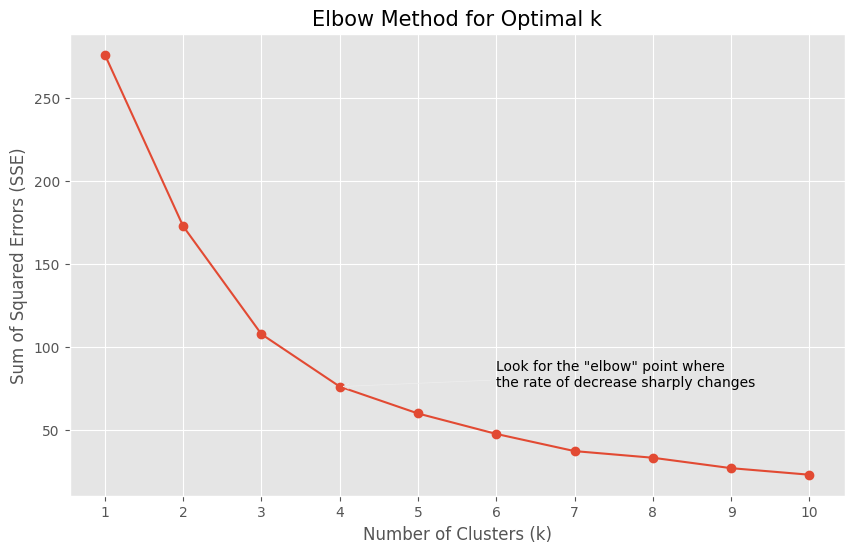

In [16]:
# Find optimal number of clusters using Elbow Method
if not rfm_scaled_df.empty:
    # Calculate SSE (inertia) for different k values
    sse = {}
    for k in range(1, 11):  # Try 1 to 10 clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled_df)
        sse[k] = kmeans.inertia_  # Sum of squared distances to closest centroid
    
    # Plot the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(list(sse.keys()), list(sse.values()), marker='o')
    plt.title('Elbow Method for Optimal k', fontsize=15)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
    plt.xticks(list(sse.keys()))
    plt.grid(True)
    
    # Add annotation about interpretation
    plt.annotate('Look for the "elbow" point where\nthe rate of decrease sharply changes', 
                 xy=(4, sse[4]), xytext=(6, sse[4]), 
                 arrowprops=dict(arrowstyle='->'), fontsize=10)
    
    # Save the figure
    plt.savefig(f"{plots_dir}/elbow_method.jpg", dpi=300, bbox_inches='tight')
    print(f"Saved Elbow Method plot to {plots_dir}/elbow_method.jpg")
    
    plt.show()

## Applying K-means Clustering

Based on the Elbow Method results, we'll apply K-means with the chosen number of clusters.
Feel free to adjust the `chosen_k` value based on your interpretation of the Elbow plot.

I'm going with 4 clusters for now - it seems like a good balance based on the elbow plot, and it's also a nice number for business folks to work with. It's easy to create marketing strategies for 4 customer groups.

In [17]:
# Apply K-means with the chosen k value
if not rfm_scaled_df.empty:
    # Choose k based on the Elbow plot
    chosen_k = 4  # Adjust this value based on your Elbow plot interpretation
    print(f"Applying K-means with k={chosen_k}")
    
    # Create and fit the model
    kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    
    # Add cluster labels to the original RFM dataframe
    df_rfm['Cluster'] = kmeans.labels_
    
    # Show cluster distribution
    print("\nNumber of customers in each cluster:")
    print(df_rfm['Cluster'].value_counts().sort_index())
    
    # Display sample of clustered data
    print("\nSample of customers with their cluster assignments:")
    display(df_rfm.head())

Applying K-means with k=4

Number of customers in each cluster:
Cluster
0    14
1    42
2     2
3    34
Name: count, dtype: int64

Sample of customers with their cluster assignments:


,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,3,157807.81,1
Alpha Cognac,65,3,70488.44,1
Amica Models & Co.,265,2,94117.26,3
"Anna's Decorations, Ltd",84,4,153996.13,1
Atelier graphique,188,3,24179.96,3


## Cluster Analysis and Visualization

Now we'll analyze the characteristics of each customer segment (cluster):
1. Calculate the mean RFM values for each cluster
2. Create visualizations to help interpret the segments
3. Draw insights about each customer segment

The fun part! Let's see what our clusters actually mean. I'll create a summary table and some visualizations that should make it easier to understand each customer group.

Mean RFM values and size of each cluster:


,Recency,Frequency,MonetaryValue,Size
Cluster,,,,
0,22.7,3.6,120444.3,14
1,159.3,3.3,112266.5,42
2,2.0,21.5,783576.1,2
3,288.5,2.2,60707.8,34


Saved cluster summary to plots/cluster_summary.csv
Saved Snake Plot to plots/snake_plot.jpg
Saved Snake Plot to plots/snake_plot.jpg


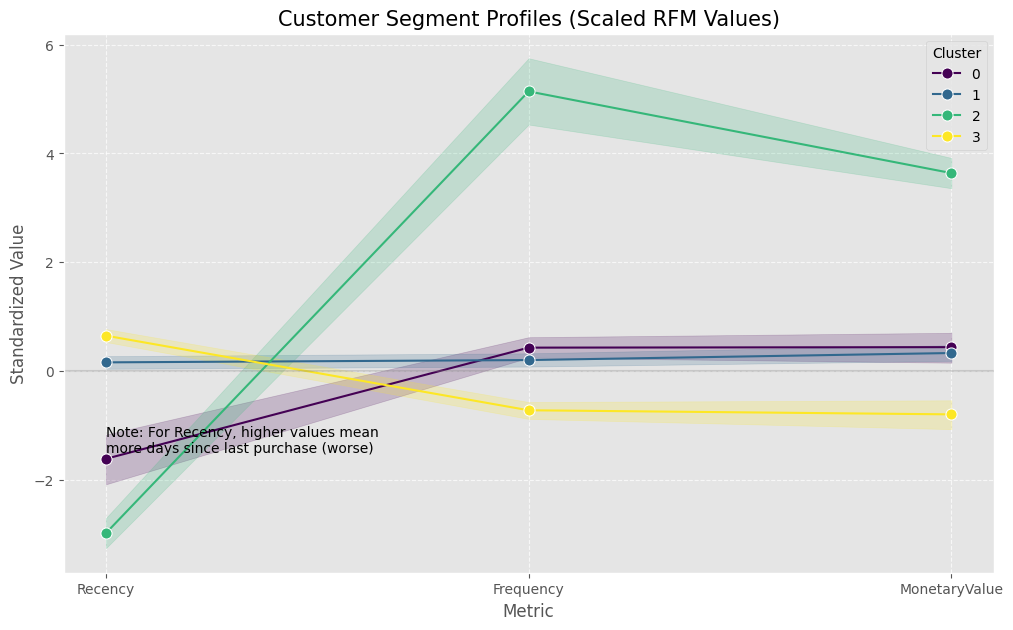

Saved Scatter Plot to plots/scatter_plot.jpg


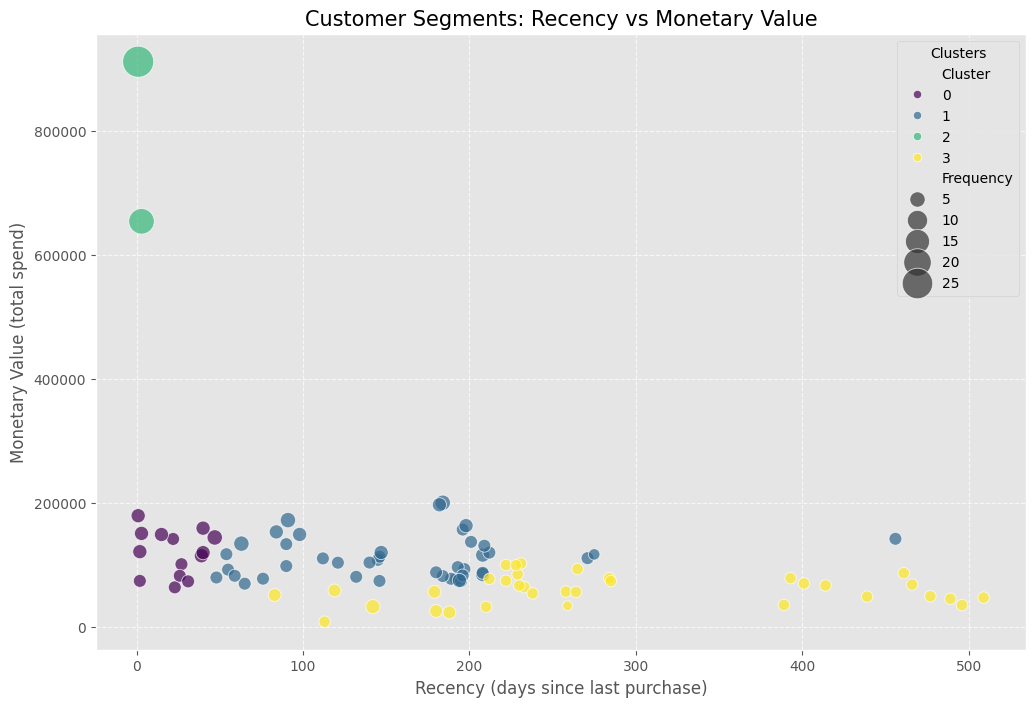

In [18]:
# Analyze and visualize the clusters
if 'Cluster' in df_rfm.columns:
    # Calculate mean RFM values for each cluster
    cluster_summary = df_rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': 'mean',
        'Cluster': 'count'
    }).rename(columns={'Cluster': 'Size'}).round(1)
    
    print("Mean RFM values and size of each cluster:")
    display(cluster_summary)
    
    # Save cluster summary as CSV for GitHub reference
    cluster_summary.to_csv(f"{plots_dir}/cluster_summary.csv")
    print(f"Saved cluster summary to {plots_dir}/cluster_summary.csv")
    
    # Create a snake plot to show relative importance of RFM for each cluster
    rfm_scaled_df['Cluster'] = kmeans.labels_
    rfm_melt = pd.melt(
        rfm_scaled_df.reset_index(),
        id_vars=['CUSTOMERNAME', 'Cluster'],
        value_vars=['Recency', 'Frequency', 'MonetaryValue'],
        var_name='Metric',
        value_name='ScaledValue'
    )
    
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=rfm_melt, x='Metric', y='ScaledValue', hue='Cluster', 
                 palette='viridis', marker='o', markersize=8)
    plt.title('Customer Segment Profiles (Scaled RFM Values)', fontsize=15)
    plt.ylabel('Standardized Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)  # Add line at y=0 (mean)
    plt.legend(title='Cluster')
    plt.annotate('Note: For Recency, higher values mean\nmore days since last purchase (worse)',
                xy=(0, -1.5), fontsize=10)
    
    # Save the snake plot
    plt.savefig(f"{plots_dir}/snake_plot.jpg", dpi=300, bbox_inches='tight')
    print(f"Saved Snake Plot to {plots_dir}/snake_plot.jpg")
    
    plt.show()
    
    # Create scatter plot of Recency vs Monetary Value (size by Frequency)
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=df_rfm, x='Recency', y='MonetaryValue', 
                             hue='Cluster', size='Frequency', sizes=(50, 500), 
                             palette='viridis', alpha=0.7)
    plt.title('Customer Segments: Recency vs Monetary Value', fontsize=15)
    plt.xlabel('Recency (days since last purchase)', fontsize=12)
    plt.ylabel('Monetary Value (total spend)', fontsize=12)
    # Adjust legend
    scatter.legend(loc='upper right', title='Clusters')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save the scatter plot
    plt.savefig(f"{plots_dir}/scatter_plot.jpg", dpi=300, bbox_inches='tight')
    print(f"Saved Scatter Plot to {plots_dir}/scatter_plot.jpg")
    
    plt.show()

Now we can name our clusters and think about what marketing strategies might work for each group. This is where the analysis becomes actually useful for the business!

## Additional Insights: Segment Profiling and Business Impact

Let's create two more visualizations to better understand our customer segments and their potential business impact:

1. A radar chart that shows the RFM characteristics of each segment in a different way
2. A heatmap showing the correlation between RFM metrics to understand the relationship between customer behaviors

Saved Radar Plot to plots/radar_plot.jpg


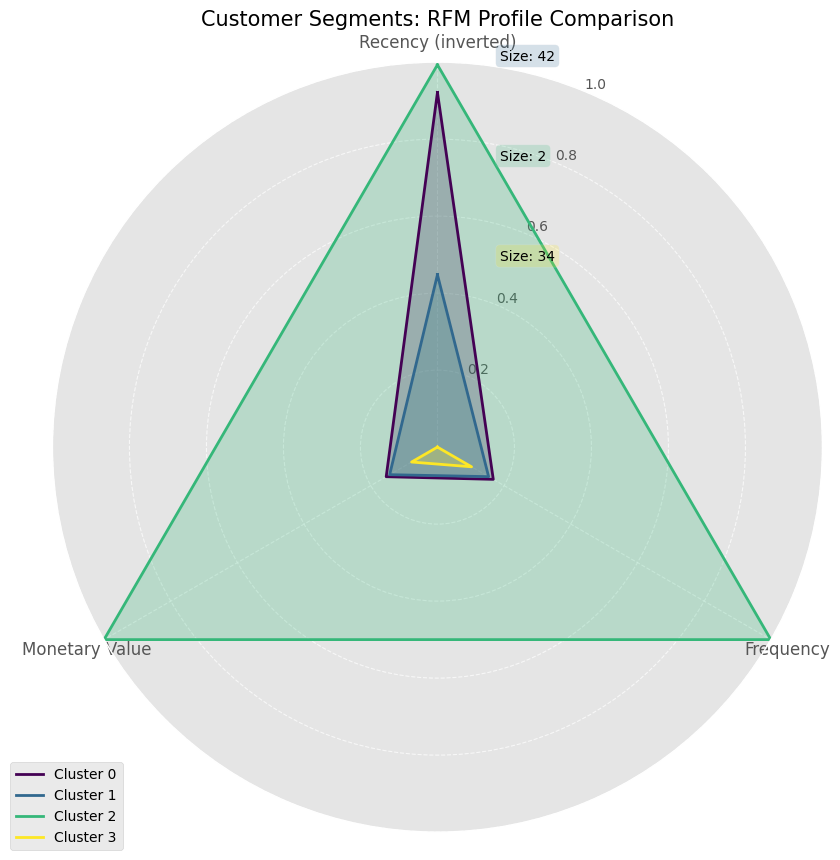

In [19]:
# Create a radar chart to visualize segment profiles
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'Cluster' in df_rfm.columns:
    # Prepare data for radar chart
    # Normalize the values for radar chart (0-1 scale)
    radar_df = cluster_summary.copy()
    
    # For Recency, lower is better, so we'll invert it 
    max_recency = radar_df['Recency'].max()
    radar_df['Recency'] = (max_recency - radar_df['Recency']) / max_recency  # Invert so higher is better
    
    # Normalize Frequency and MonetaryValue (higher is better)
    radar_df['Frequency'] = radar_df['Frequency'] / radar_df['Frequency'].max()
    radar_df['MonetaryValue'] = radar_df['MonetaryValue'] / radar_df['MonetaryValue'].max()
    
    # Create radar chart with multiple clusters
    categories = ['Recency (inverted)', 'Frequency', 'Monetary Value']
    N = len(categories)
    
    # Create angles for radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Set the angle labels
    plt.xticks(angles[:-1], categories, fontsize=12)
    
    # Draw one axis per variable and add labels
    ax.set_theta_offset(np.pi / 2)  # Rotate to start at top
    ax.set_theta_direction(-1)  # Go clockwise
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    # Create colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(radar_df)))
    
    # Plot each cluster
    for i, (idx, row) in enumerate(radar_df.iterrows()):
        values = row[['Recency', 'Frequency', 'MonetaryValue']].tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=colors[i], label=f'Cluster {idx}')
        ax.fill(angles, values, color=colors[i], alpha=0.25)
    
    # Add cluster size annotations
    for i, (idx, row) in enumerate(radar_df.iterrows()):
        plt.annotate(f'Size: {int(row["Size"])}',
                    xy=(0.5, 0.9-i*0.1), 
                    xycoords='figure fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc=colors[i], alpha=0.2))
        
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title('Customer Segments: RFM Profile Comparison', fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save the radar plot
    plt.savefig(f"{plots_dir}/radar_plot.jpg", dpi=300, bbox_inches='tight')
    print(f"Saved Radar Plot to {plots_dir}/radar_plot.jpg")
    
    plt.show()

Saved Correlation & Distribution Plot to plots/correlation_and_distribution.jpg


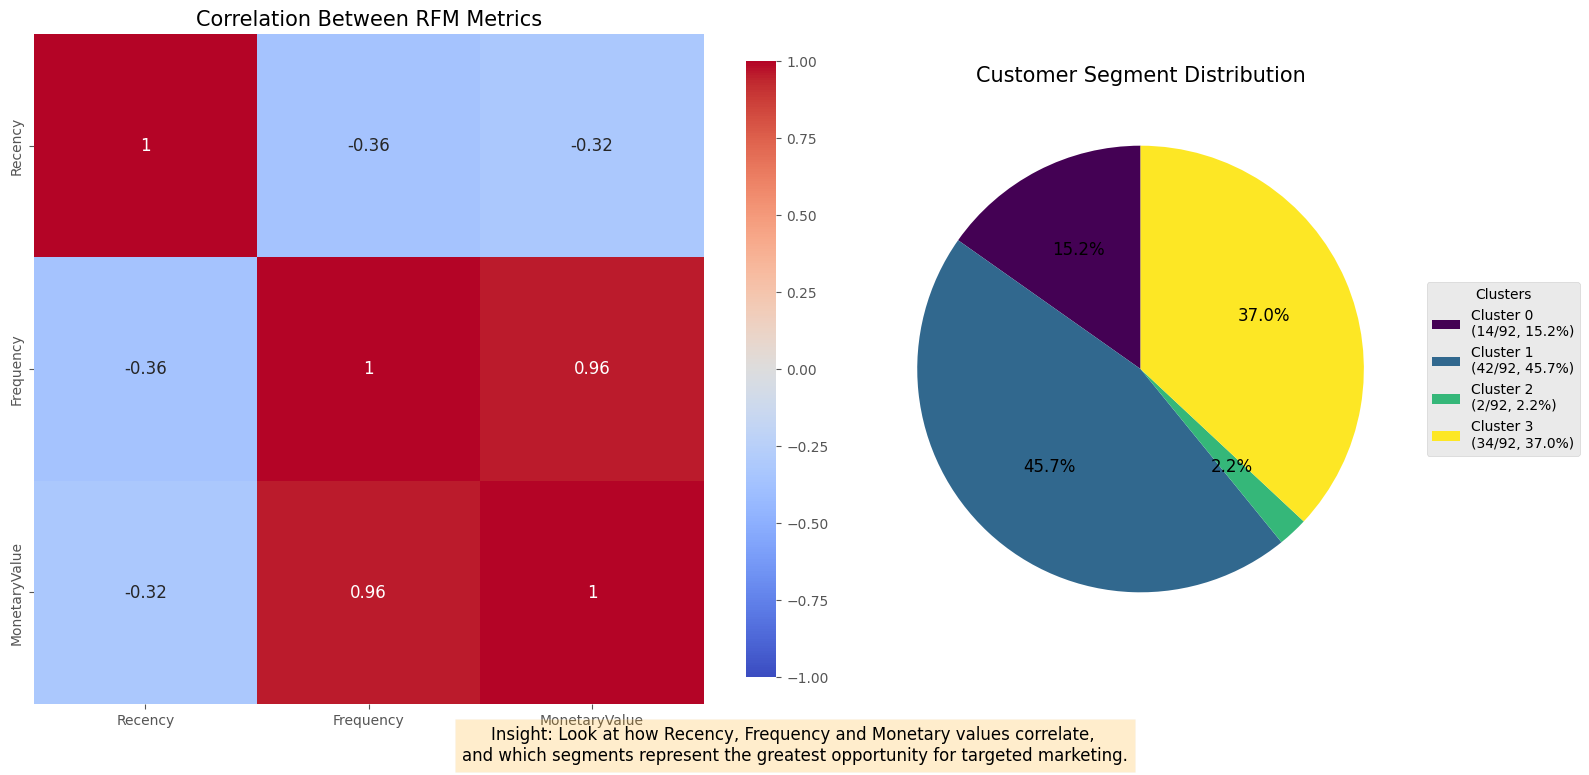

In [20]:
# Create a correlation heatmap to understand relationships between RFM metrics
# and add segment distribution pie chart
import matplotlib.gridspec as gridspec

if not df_rfm.empty:
    # Set up the figure with grid layout
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])
    
    # 1. Correlation Heatmap
    ax0 = plt.subplot(gs[0])
    
    # Calculate correlation matrix for RFM values
    corr = df_rfm[['Recency', 'Frequency', 'MonetaryValue']].corr()
    
    # Create heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax0,
               annot_kws={"size": 12}, square=True, cbar_kws={"shrink": 0.8})
    
    ax0.set_title('Correlation Between RFM Metrics', fontsize=15)
    
    # 2. Cluster Size Distribution (Pie Chart)
    ax1 = plt.subplot(gs[1])
    
    # Get cluster sizes
    cluster_sizes = df_rfm['Cluster'].value_counts().sort_index()
    
    # Define labels with percentages
    total = cluster_sizes.sum()
    labels = [f'Cluster {i}\n({size}/{total}, {size/total:.1%})' for i, size in cluster_sizes.items()]
    
    # Create pie chart
    wedges, texts, autotexts = ax1.pie(cluster_sizes, 
                                      autopct='%1.1f%%',
                                      textprops={'fontsize': 12},
                                      startangle=90,
                                      colors=plt.cm.viridis(np.linspace(0, 1, len(cluster_sizes))))
    
    # Add labels and title
    ax1.set_title('Customer Segment Distribution', fontsize=15)
    ax1.legend(wedges, labels, title="Clusters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Add insights
    plt.figtext(0.5, 0.01, "Insight: Look at how Recency, Frequency and Monetary values correlate, \n" +
               "and which segments represent the greatest opportunity for targeted marketing.", 
               ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"{plots_dir}/correlation_and_distribution.jpg", dpi=300, bbox_inches='tight')
    print(f"Saved Correlation & Distribution Plot to {plots_dir}/correlation_and_distribution.jpg")
    
    plt.show()

## Actionable Business Strategies by Segment

Based on our enhanced analysis, we can now define specific marketing strategies for each customer segment:

In [21]:
# Create a table of recommended strategies by segment
import pandas as pd
from IPython.display import display, HTML

# Define segment names based on RFM characteristics
if 'Cluster' in df_rfm.columns:
    # Find the best cluster (lowest Recency, highest Frequency and MonetaryValue)
    best_cluster = cluster_summary[['Recency', 'Frequency', 'MonetaryValue']].apply(
        lambda x: (max(x) - x['Recency']) + x['Frequency'] + x['MonetaryValue'], axis=1).idxmax()
    
    # Find the at-risk cluster (high Recency, medium/high Freq/Monetary)
    at_risk = cluster_summary[cluster_summary['Recency'] > cluster_summary['Recency'].median()].index
    non_best = [i for i in cluster_summary.index if i != best_cluster]
    
    # Define segment names and strategies
    segment_strategies = pd.DataFrame({
        'Segment Name': ['Champions', 'At-Risk High Value', 'Potential Loyalists', 'Need Attention'],
        'Likely Cluster': [f'Cluster {best_cluster}', 
                          f'Cluster {at_risk[0]}', 
                          f'Cluster {non_best[0]}', 
                          f'Cluster {non_best[1] if len(non_best) > 1 else non_best[0]}'],
        'RFM Characteristics': [
            'Low Recency, High Frequency, High Monetary',
            'High Recency, Medium/High Frequency/Monetary',
            'Low/Med Recency, Medium Frequency/Monetary',
            'High Recency, Low Frequency/Monetary'
        ],
        'Marketing Strategy': [
            'Loyalty rewards, exclusive offers, referral programs',
            'Reactivation campaigns, special incentives, "we miss you" offers',
            'Engagement programs, cross-selling, personalized recommendations',
            'Win-back campaigns, surveys to understand needs, educational content'
        ]
    })
    
    # Display as HTML table with styling
    display(HTML(segment_strategies.to_html(index=False, escape=False, classes='table table-striped')))
    
    # Export to HTML for GitHub
    with open(f"{plots_dir}/segment_strategies.html", 'w') as f:
        f.write(segment_strategies.to_html(index=False, classes='table table-striped'))
    print(f"Saved segment strategies to {plots_dir}/segment_strategies.html")

Segment Name,Likely Cluster,RFM Characteristics,Marketing Strategy
Champions,Cluster 2,"Low Recency, High Frequency, High Monetary","Loyalty rewards, exclusive offers, referral programs"
At-Risk High Value,Cluster 1,"High Recency, Medium/High Frequency/Monetary","Reactivation campaigns, special incentives, ""we miss you"" offers"
Potential Loyalists,Cluster 0,"Low/Med Recency, Medium Frequency/Monetary","Engagement programs, cross-selling, personalized recommendations"
Need Attention,Cluster 1,"High Recency, Low Frequency/Monetary","Win-back campaigns, surveys to understand needs, educational content"


Saved segment strategies to plots/segment_strategies.html


## Interpretation of Customer Segments

Based on the cluster analysis, we can interpret our customer segments. Remember:
* **Low Recency** is good (purchased recently)
* **High Frequency** is good (purchased often)
* **High Monetary Value** is good (spent more)

Typical segments might include:

1. **Champions**: Low Recency, High Frequency, High Monetary - your best customers
2. **Potential Loyalists**: Low Recency, Medium Frequency, Medium Monetary - recent customers with potential
3. **At-Risk Customers**: High Recency, Medium/High Frequency/Monetary - previous valuable customers who haven't purchased recently
4. **Need Attention**: Medium Recency, Low Frequency, Low Monetary - customers who might churn if not engaged

Look at the cluster summary table and visualizations to match these personas to your specific cluster numbers.

That's it! I've successfully segmented our customers using RFM analysis and K-means clustering. The marketing team can now use these segments to create targeted campaigns instead of using the same approach for everyone. For example, we might want to send our Champions a loyalty reward, while our At-Risk customers might need a special reactivation offer.